In [1]:
import pandas as pd

df = pd.read_csv("electricity.csv")

# Check shape, dtypes, and missing values
print("Shape:", df.shape)
print("\nData types:\n", df.dtypes.head())
print("\nMissing values (non-zero):\n", df.isnull().sum()[df.isnull().sum() > 0])


Shape: (17544, 1579)

Data types:
 timestamp                    object
Panther_parking_Lorriane    float64
Panther_lodging_Cora        float64
Panther_office_Hannah       float64
Panther_lodging_Hattie      float64
dtype: object

Missing values (non-zero):
 Panther_parking_Lorriane       11
Panther_lodging_Cora           11
Panther_office_Hannah          12
Panther_lodging_Hattie         12
Panther_education_Teofila      11
                             ... 
Cockatoo_education_Tyler     1428
Cockatoo_public_Shad         1431
Mouse_health_Buddy             61
Mouse_health_Modesto            4
Mouse_health_Ileana           165
Length: 1205, dtype: int64


In [14]:
# Exclude timestamp column
meter_columns = df.columns[1:]

# Parse each name into Site, Type, Name
parsed = [col.split('_') for col in meter_columns]
building_meta = pd.DataFrame(parsed, columns=['Site', 'Type', 'Name'])
building_meta['Meter'] = meter_columns


In [15]:
# Count by Campus
site_dist = building_meta['Site'].value_counts()

# Count by Type
type_dist = building_meta['Type'].value_counts()

print("Meter count by Site:\n", site_dist)
print("\nMeter count by Type:\n", type_dist)


Meter count by Site:
 Site
Rat         305
Hog         152
Lamb        146
Fox         137
Bull        123
Cockatoo    117
Eagle       106
Panther     105
Bear         92
Gator        74
Robin        52
Peacock      45
Wolf         36
Bobcat       35
Swan         19
Moose        13
Shrew         9
Mouse         7
Crow          5
Name: count, dtype: int64

Meter count by Type:
 Type
education     604
office        296
assembly      203
public        166
lodging       149
health         27
other          26
parking        23
unknown        19
warehouse      14
retail         11
industrial     11
services        9
science         7
food            6
utility         4
religion        3
Name: count, dtype: int64


In [16]:
# Get missing counts from the original dataframe
missing_counts = df[meter_columns].isnull().sum().reset_index()
missing_counts.columns = ['Meter', 'MissingCount']

# Merge with meta
building_meta = pd.merge(building_meta, missing_counts, on='Meter')

# Missing by Campus
missing_by_site = building_meta.groupby('Site')['MissingCount'].sum().sort_values(ascending=False)

# Missing by Type
missing_by_type = building_meta.groupby('Type')['MissingCount'].sum().sort_values(ascending=False)

print("\nTotal missing values by Site:\n", missing_by_site)
print("\nTotal missing values by Type:\n", missing_by_type)



Total missing values by Site:
 Site
Rat         405433
Cockatoo    188193
Swan        167111
Bobcat      155844
Gator       117532
Peacock      98052
Bear         58347
Eagle        41758
Fox          20230
Panther      16748
Moose         9967
Lamb          8894
Robin         8765
Crow          6884
Bull          4476
Hog           3062
Wolf           569
Mouse          230
Shrew            0
Name: MissingCount, dtype: int64

Total missing values by Type:
 Type
education     531266
public        176559
unknown       167111
office        150812
assembly      148925
lodging        71517
other          21838
science        12365
health         11608
parking         6236
warehouse       4574
utility         4529
industrial      2926
religion        1480
services         145
food             103
retail           101
Name: MissingCount, dtype: int64


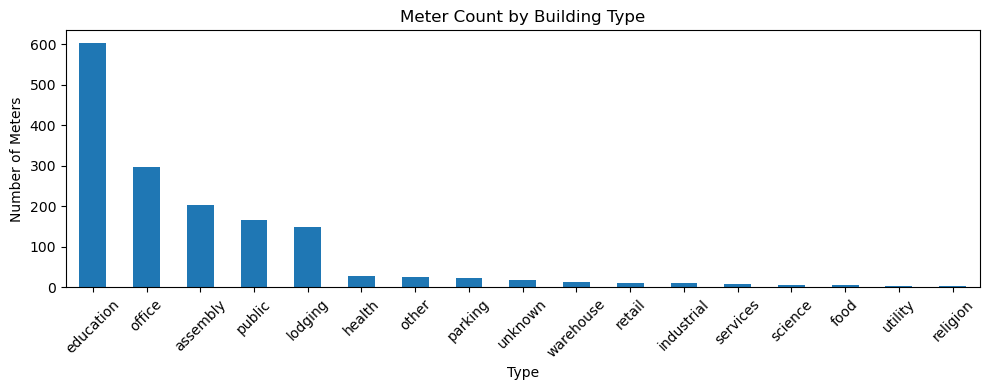

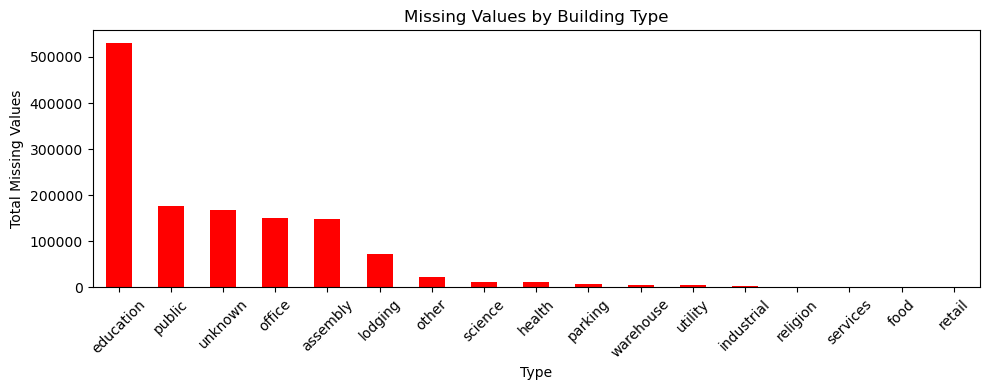

In [17]:
# Plot meter distribution by type
type_dist.plot(kind='bar', figsize=(10, 4), title='Meter Count by Building Type')
plt.ylabel("Number of Meters")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot missing by type
missing_by_type.plot(kind='bar', color='red', figsize=(10, 4), title='Missing Values by Building Type')
plt.ylabel("Total Missing Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


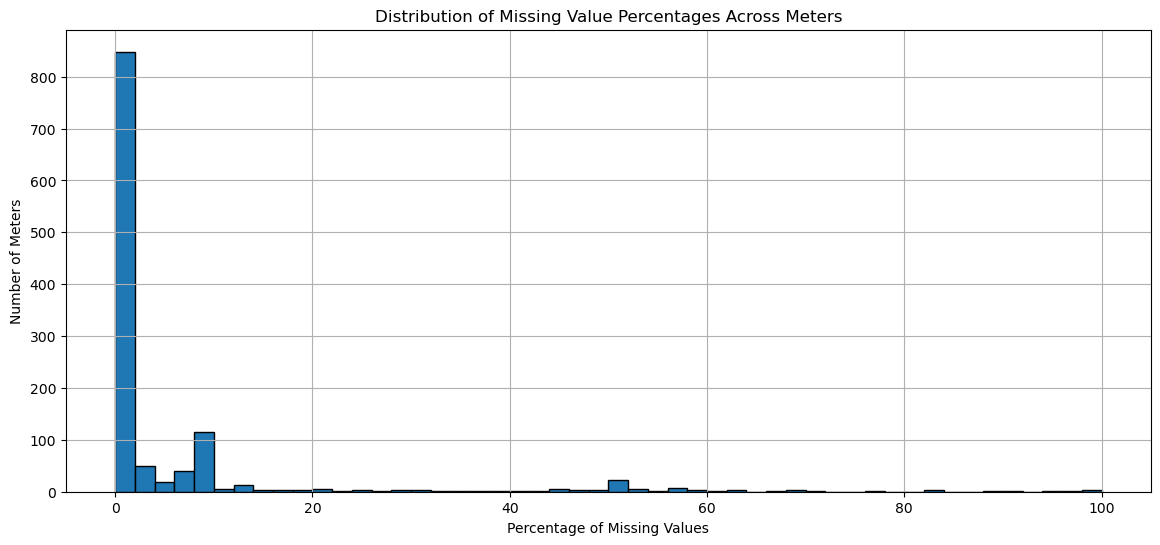

In [2]:
import matplotlib.pyplot as plt

# 1. Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2. Visualize missing value distribution
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

# Plot missing value distribution
plt.figure(figsize=(14,6))
plt.hist(missing_percentage, bins=50, edgecolor='black')
plt.title('Distribution of Missing Value Percentages Across Meters')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Meters')
plt.grid(True)
plt.show()


A large majority of meters have 0–5% missing data — totally manageable.

A small but significant tail exists where some meters have >80% missing

In [3]:
# Get top 20 meters with highest missing percentage
top_missing = missing_percentage.sort_values(ascending=False).head(20)

# Convert to DataFrame for better display
top_missing_df = top_missing.reset_index()
top_missing_df.columns = ['Meter', 'Missing Percentage']

# Print the result
print(top_missing_df)

                       Meter  Missing Percentage
0         Rat_public_Ulysses          100.000000
1      Eagle_lodging_Garland          100.000000
2    Bobcat_education_Barbra           99.373005
3      Bobcat_education_Seth           96.243730
4          Rat_education_Mac           94.795942
5     Rat_education_Angelica           91.375969
6      Rat_education_Kristie           91.102371
7       Rat_education_Chance           89.871181
8       Peacock_public_Linda           83.595531
9        Bobcat_public_Angie           83.008436
10    Bobcat_education_Emile           82.689238
11  Bobcat_education_Rodrick           77.599179
12    Rat_education_Veronica           77.428181
13      Rat_education_Moises           71.414729
14     Rat_education_Abigail           68.815549
15          Rat_public_Percy           68.268354
16      Rat_education_Alonzo           68.131555
17      Peacock_office_Naomi           67.567259
18       Rat_education_Penny           63.753990
19     Rat_education

In [4]:
# Drop columns (meters) with >80% missing data
columns_to_drop = missing_percentage[missing_percentage > 80].index
df_cleaned = df.drop(columns=columns_to_drop)

# Convert timestamp to datetime
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# Interpolate missing values
df_cleaned = df_cleaned.set_index('timestamp')  # Set timestamp as index
df_cleaned = df_cleaned.interpolate(method='time')  # Time-based interpolation
df_cleaned = df_cleaned.reset_index()  # Restore timestamp

# Report total remaining NaNs
remaining_nans = df_cleaned.isnull().sum().sum()
print(f"Total remaining NaN values after cleaning and interpolation: {remaining_nans}")


Total remaining NaN values after cleaning and interpolation: 344204


In [5]:
df_cleaned = df_cleaned.fillna(method='ffill').fillna(method='bfill')
print("NaNs remaining after ffill + bfill:", df_cleaned.isnull().sum().sum())


NaNs remaining after ffill + bfill: 0


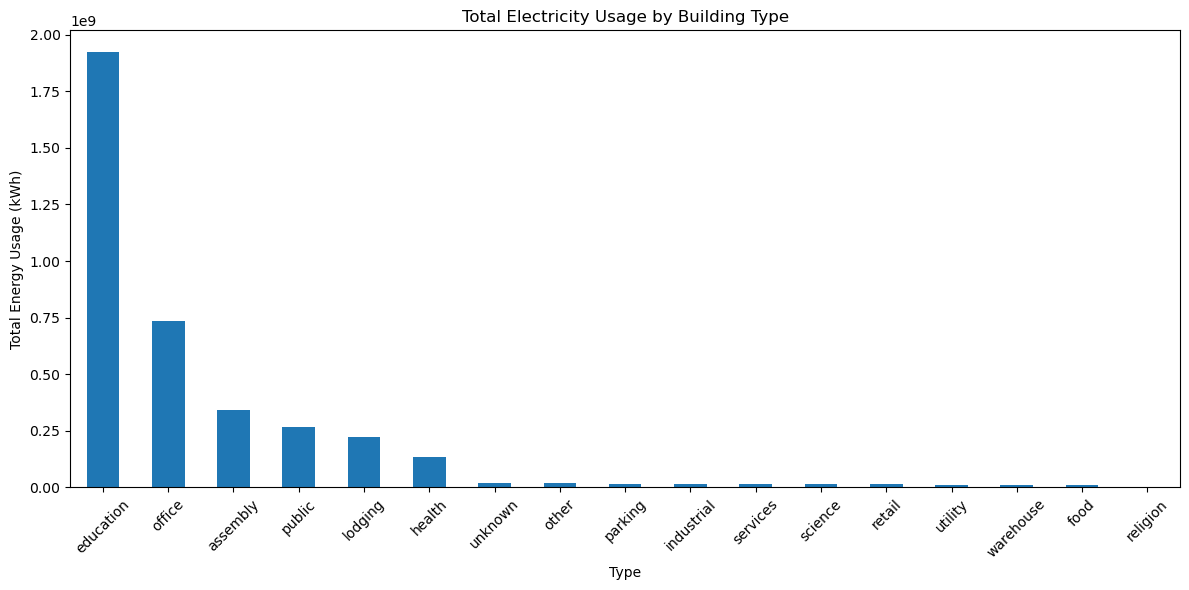

In [8]:
# Define meter columns
meter_columns = df_cleaned.columns[1:]

# Step 1: Get total usage per meter
meter_totals = df_cleaned[meter_columns].sum().reset_index()
meter_totals.columns = ['Meter', 'TotalUsage']

# Step 2: Extract building type
building_types = [col.split('_')[1] for col in meter_columns]
building_type_df = pd.DataFrame({'Meter': meter_columns, 'Type': building_types})

# Step 3: Merge and group by type
meter_usage_with_type = pd.merge(meter_totals, building_type_df, on='Meter')
total_usage_by_type = meter_usage_with_type.groupby('Type')['TotalUsage'].sum().sort_values(ascending=False)

# Step 4: Plot
import matplotlib.pyplot as plt
total_usage_by_type.plot(kind='bar', figsize=(12, 6), title='Total Electricity Usage by Building Type')
plt.ylabel('Total Energy Usage (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
# Which meters have been deleted?
dropped_meters = missing_percentage[missing_percentage > 80].index
dropped_info = building_meta[building_meta['Meter'].isin(dropped_meters)]

# The distribution of deleted meters. 
drop_by_type = dropped_info['Type'].value_counts()
drop_by_site = dropped_info['Site'].value_counts()

print("Dropped meters by type:\n", drop_by_type)
print("\nDropped meters by site:\n", drop_by_site)


Dropped meters by type:
 Type
education    7
public       3
lodging      1
Name: count, dtype: int64

Dropped meters by site:
 Site
Rat        5
Bobcat     4
Peacock    1
Eagle      1
Name: count, dtype: int64


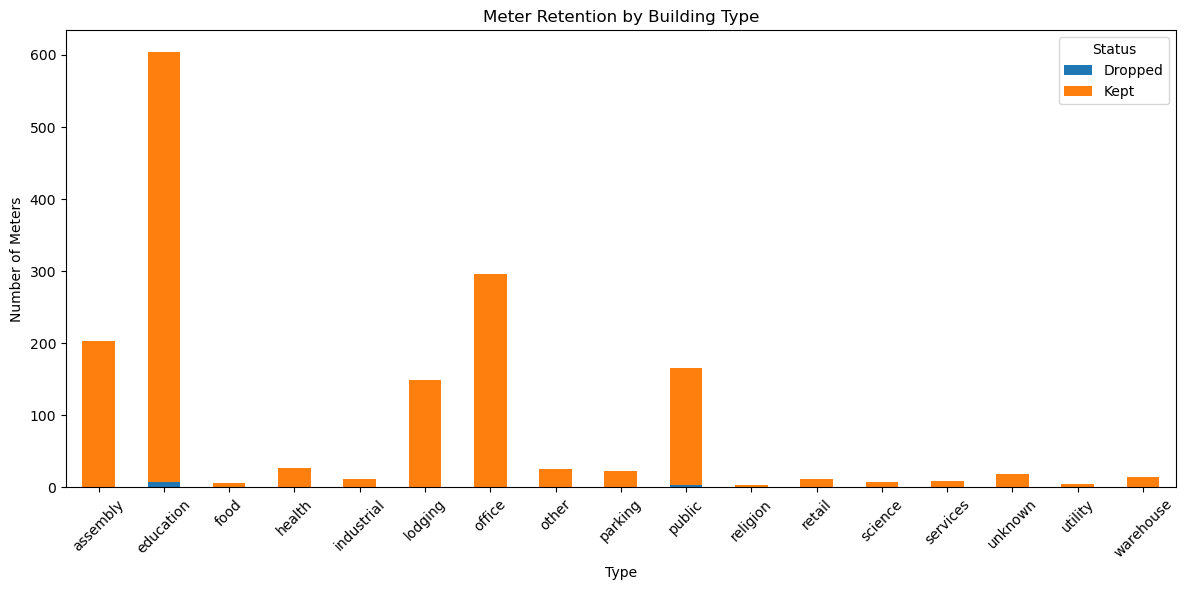

In [19]:
# Label meters as kept or dropped
building_meta['Status'] = building_meta['Meter'].apply(lambda x: 'Dropped' if x in dropped_meters else 'Kept')

# Group and count by Type and Status
type_status_counts = building_meta.groupby(['Type', 'Status'])['Meter'].count().unstack().fillna(0)

# Plot stacked bar chart
type_status_counts.plot(kind='bar', stacked=True, figsize=(12, 6), 
                        title='Meter Retention by Building Type')
plt.ylabel('Number of Meters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


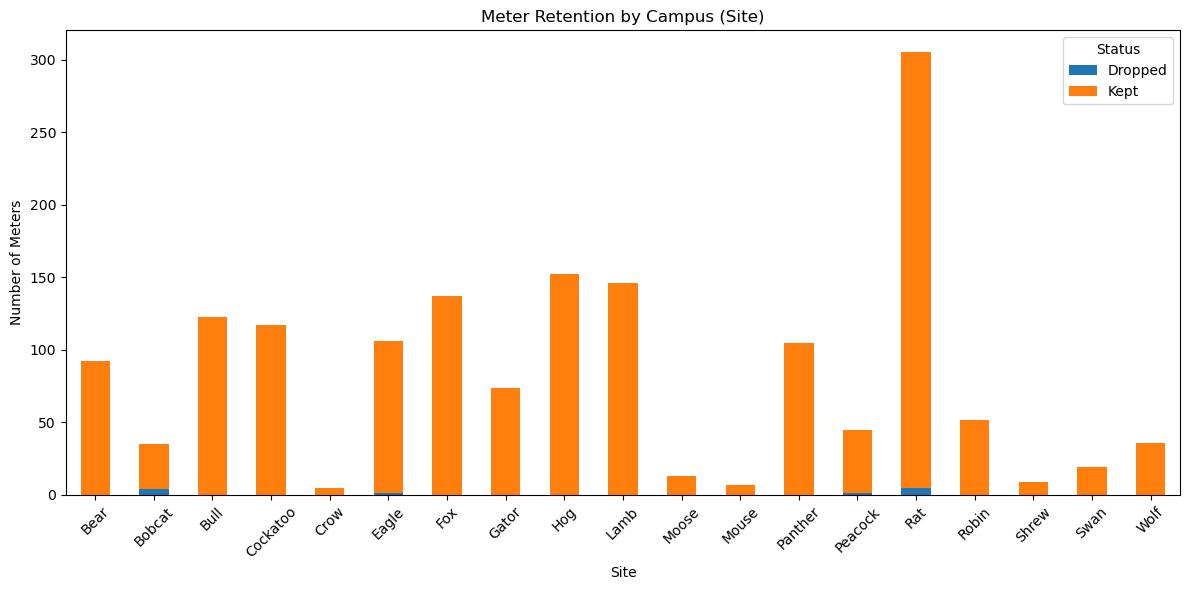

In [20]:
# Group and count by Site and Status
site_status_counts = building_meta.groupby(['Site', 'Status'])['Meter'].count().unstack().fillna(0)

# Plot stacked bar chart
site_status_counts.plot(kind='bar', stacked=True, figsize=(12, 6), 
                        title='Meter Retention by Campus (Site)')
plt.ylabel('Number of Meters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


* 1. Meter Retention by Building Type

Most types (education, office, lodging, etc.) have nearly all meters retained.

Only a few meters were dropped even from the most common types.

No type was completely wiped out, even for small categories like religion, food, retail.

Dropping threshold (>80% missing) was conservative enough to preserve diversity across types.

* 2. Meter Retention by Campus (Site)

Almost every campus still retains the majority of its meters.

Only a few drops occurred in Bobcat, Rat, Peacock, etc., and even there the drop count is tiny relative to total meters.

No campus lost a major portion of its data.